# Import Library

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

In [3]:
# Definisikan path ke direktori data
base_dir = 'Datasets2'
features = ['scenery', 'environment', 'category']

# Fungsi untuk menghitung jumlah file dalam direktori
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len([file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.webp'))])
    return total_files

# Menghitung jumlah file untuk setiap fitur dan labela
for feature in features:
    feature_dir = os.path.join(base_dir, feature)
    print(f'Output: {feature}')
    for label in os.listdir(feature_dir):
        label_dir = os.path.join(feature_dir, label)
        if os.path.isdir(label_dir):
            num_files = count_files_in_directory(label_dir)
            print(f'  Label: {label}, Number of files: {num_files}')


Output: scenery
  Label: nature, Number of files: 900
  Label: urban, Number of files: 900
Output: environment
  Label: land, Number of files: 900
  Label: water, Number of files: 900
Output: category
  Label: attractions, Number of files: 900
  Label: historical, Number of files: 900
  Label: greenery, Number of files: 900


# Data Pre-Processing

In [4]:
sce_dir = os.path.join(base_dir, 'scenery')
env_dir = os.path.join(base_dir, 'environment')
cat_dir = os.path.join(base_dir, 'category')

In [5]:
# Tentukan ukuran gambar yang diinginkan
img_width, img_height = 224, 224
batch_size = 32

# Fungsi untuk membuat generator dengan data augmentation
def create_gen(base_dir, img_width, img_height, batch_size, subset):
    if subset == 'training':
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    generator = datagen.flow_from_directory(
        base_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset,
        shuffle=True)
    return generator

# Membuat generator untuk setiap fitur
sce_train_gen = create_gen(sce_dir, img_width, img_height, batch_size, 'training')
env_train_gen = create_gen(env_dir, img_width, img_height, batch_size, 'training')
cat_train_gen = create_gen(cat_dir, img_width, img_height, batch_size, 'training')

sce_val_gen = create_gen(sce_dir, img_width, img_height, batch_size, 'validation')
env_val_gen = create_gen(env_dir, img_width, img_height, batch_size, 'validation')
cat_val_gen = create_gen(cat_dir, img_width, img_height, batch_size, 'validation')

Found 1437 images belonging to 2 classes.
Found 1417 images belonging to 2 classes.
Found 2133 images belonging to 3 classes.
Found 358 images belonging to 2 classes.
Found 353 images belonging to 2 classes.
Found 532 images belonging to 3 classes.


In [70]:
def show_example_images(generator, images_per_class=1):
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    
    images, labels = next(generator)

    # Create a list to store selected images and their corresponding labels
    selected_images = []
    selected_labels = []

    # Iterate through each class and select a specified number of images
    for class_name in class_names:
        class_index = class_indices[class_name]
        class_images = [img for img, lbl in zip(images, labels) if np.argmax(lbl) == class_index]
        class_labels = [lbl for lbl in labels if np.argmax(lbl) == class_index]

        # If there are fewer images than requested, use all available images
        if len(class_images) < images_per_class:
            selected_images.extend(class_images)
            selected_labels.extend(class_labels)
        else:
            selected_indices = random.sample(range(len(class_images)), images_per_class)
            selected_images.extend([class_images[idx] for idx in selected_indices])
            selected_labels.extend([class_labels[idx] for idx in selected_indices])

    num_images = len(selected_images)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i])
        plt.axis("off")

        class_index = np.argmax(selected_labels[i])
        class_name = class_names[class_index]

        plt.title(class_name, fontsize=12)
    
    plt.show()

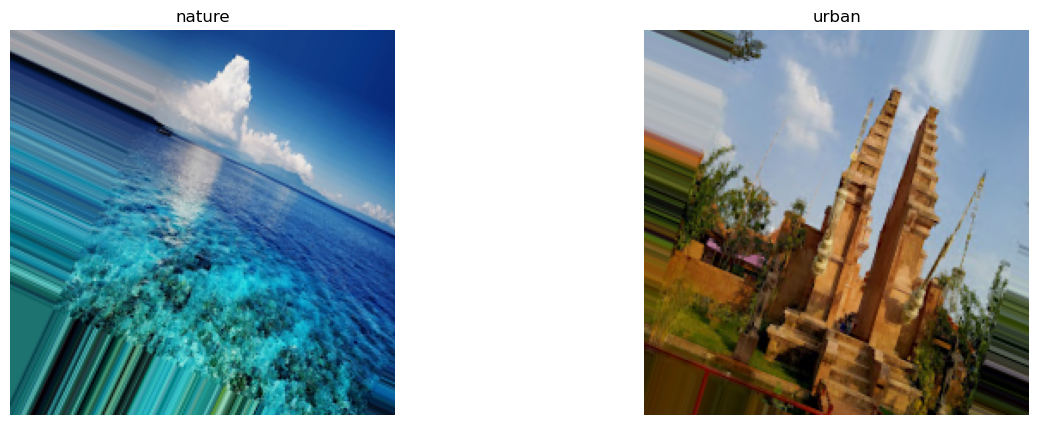

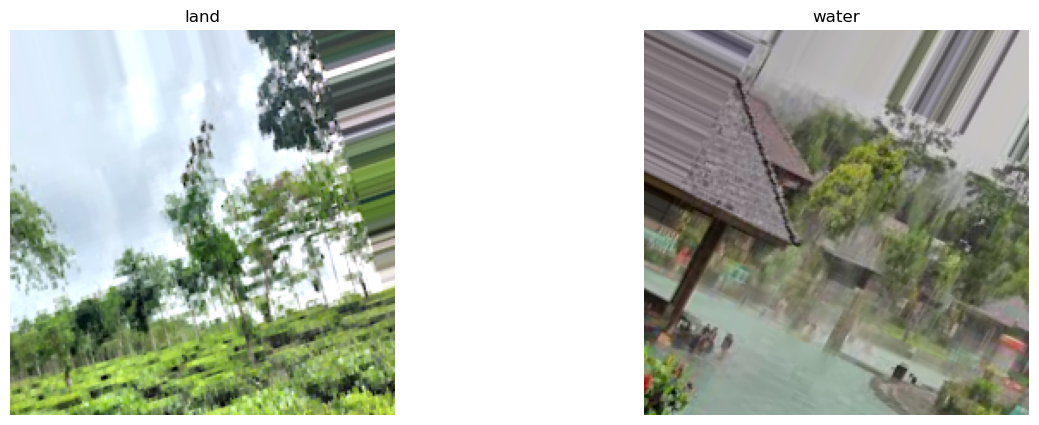

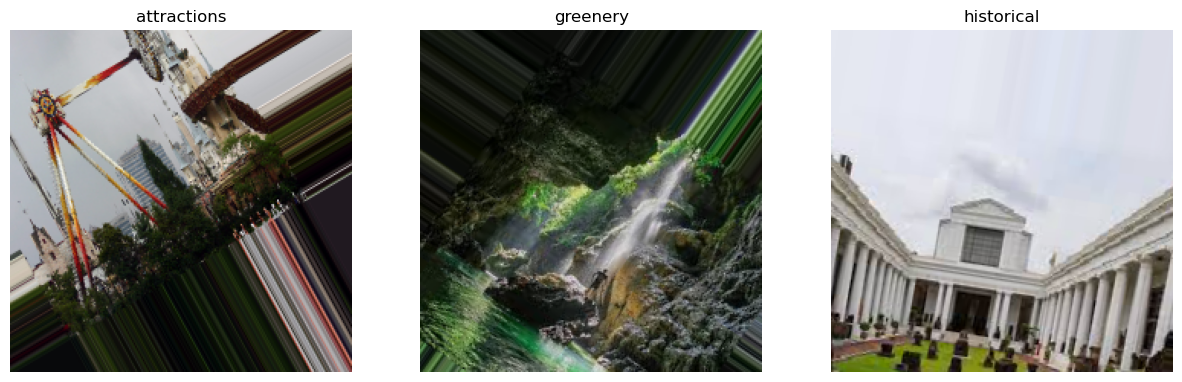

In [71]:
# Menampilkan contoh gambar dari train_generator
show_example_images(sce_train_gen, images_per_class=1)  
show_example_images(env_train_gen, images_per_class=1)  
show_example_images(cat_train_gen, images_per_class=1)  


# Model Architecture

In [72]:
base_model = MobileNetV2(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')

# Unfreeze some of the layers in the base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

inputs = Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output scenery
scenery = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
scenery = Dropout(0.5)(scenery)
scenery_output = Dense(2, activation='softmax', name='scenery')(scenery)

# Output environment
environment = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
environment = Dropout(0.5)(environment)
environment = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(environment)
environment = Dropout(0.5)(environment)
environment_output = Dense(2, activation='softmax', name='environment')(environment)

# Output category
category = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
category = Dropout(0.5)(category)
category = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(category)
category = Dropout(0.5)(category)
category = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(category)
category = Dropout(0.5)(category)
category_output = Dense(3, activation='softmax', name='category')(category)

sce_model = Model(inputs=inputs, outputs=scenery_output)
env_model = Model(inputs=inputs, outputs=environment_output)
cat_model = Model(inputs=inputs, outputs=category_output)

# Compile the model with a different learning rate
learning_rate = 0.0001

sce_opt = Adam(learning_rate=learning_rate)
env_opt = Adam(learning_rate=learning_rate)
cat_opt = Adam(learning_rate=learning_rate)

sce_model.compile(optimizer=sce_opt,
              loss={'scenery': 'binary_crossentropy'},
              metrics={'scenery': 'accuracy'})
env_model.compile(optimizer=env_opt,
              loss={'environment': 'binary_crossentropy'},
              metrics={'environment': 'accuracy'})
cat_model.compile(optimizer=cat_opt,
              loss={'category': 'categorical_crossentropy'},
              metrics={'category': 'accuracy'})

In [73]:
sce_model.summary()
env_model.summary()
cat_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scenery (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,698 (11.62 MB)

 Trainable params: 3,011,586 (11.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ environment (Dense)             │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964,994 (15.13 MB)

 Trainable params: 3,930,882 (15.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ category (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,067 (15.63 MB)

 Trainable params: 4,061,955 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Training the Model

In [ ]:
# def generator_to_dataset(generator):
#     def gen():
#         for (images, labels) in generator:
#             yield images, tuple(labels)

#     output_signature = (
#         tf.TensorSpec(shape=(None, img_width, img_height, 3), dtype=tf.float32),
#         (
#             tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
#             tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
#             tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
#         )
#     )

#     return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

# train_set = generator_to_dataset(train_gen)
# val_set = generator_to_dataset(val_gen)


In [74]:
# Adding callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


scenery_history = sce_model.fit(
    sce_train_gen,
    validation_data=sce_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Train environment output
environment_history = env_model.fit(
    env_train_gen,
    validation_data=env_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Train category output
category_history = cat_model.fit(
    cat_train_gen,
    validation_data=cat_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


C:\Users\ridho\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7377 - loss: 11.0044 - val_accuracy: 0.8017 - val_loss: 10.1279 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9423 - loss: 9.5438 - val_accuracy: 0.9078 - val_loss: 8.7795 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9583 - loss: 8.3852 - val_accuracy: 0.9441 - val_loss: 7.6463 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9571 - loss: 7.3372 - val_accuracy: 0.9665 - val_loss: 6.6125 - learning_rate: 1.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9781 - loss: 6.3614 - val_accuracy: 0.9609 - val_loss: 5.7528 - learning_rate: 1.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9739 - loss: 5.5146 - val_accuracy: 0.9665 - val_loss: 4.9659 - learning_rate: 1.0000e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9749 - loss: 4.7618 

# Evaluation and Save the Model

In [75]:
# Save scenery model
sce_model.save("Model/sce_model.h5")

# Save environment model
env_model.save("Model/env_model.h5")

# Save category model
cat_model.save("Model/cat_model.h5")


In [ ]:
# Define input layer
input_layer = Input(shape=(img_width, img_height, 3))

# Get the outputs from each individual model
scenery_output = sce_model(input_layer)
environment_output = env_model(input_layer)
category_output = cat_model(input_layer)

# Combine the outputs into a single list
combined_outputs = [scenery_output, environment_output, category_output]

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=combined_outputs)

# Compile the combined model
# You need to define appropriate loss functions and metrics for each output
combined_model.compile(optimizer='adam', 
                       loss=['binary_crossentropy', 'binary_crossentropy', 'categorical_crossentropy'],
                       metrics=['accuracy', 'accuracy', 'accuracy'])

# Summary of the combined model
combined_model.summary()

In [78]:
combined_model.save("Model/combined_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Scenery Prediction: [[2.2360973e-10 1.0000000e+00]]
Environment Prediction: [[9.9999535e-01 4.6727464e-06]]
Category Prediction: [[8.6769378e-03 9.3242247e-04 9.9039054e-01]]


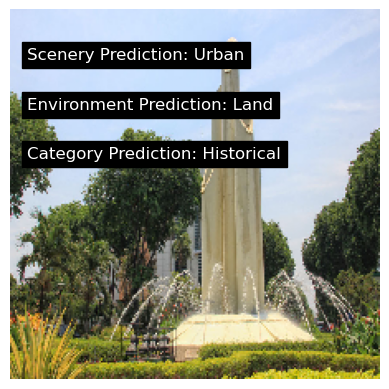

In [6]:
loaded_combined_model = load_model("Model/combined_model.h5")
# Load an example image from the dataset
image_path = "Test/test1.jpg" 
test_image = image.load_img(image_path, target_size=(img_width, img_height))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Preprocess the image
test_image = test_image / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the combined model
predictions = loaded_combined_model.predict(test_image)

# Interpret the predictions
scenery_prediction = predictions[0]  # Output for scenery
environment_prediction = predictions[1]  # Output for environment
category_prediction = predictions[2]  # Output for category

# Example: Print the predicted labels
print("Scenery Prediction:", scenery_prediction)
print("Environment Prediction:", environment_prediction)
print("Category Prediction:", category_prediction)

# Define the class labels for interpretation
scenery_classes = ['Nature', 'Urban']
environment_classes = ['Land', 'Water']
category_classes = ['Attraction', 'Greenery', 'Historical']

# Show the image
plt.imshow(test_image[0])
plt.axis('off')

# Add text annotations for predictions
scenery_label = scenery_classes[np.argmax(scenery_prediction)]
environment_label = environment_classes[np.argmax(environment_prediction)]
category_label = category_classes[np.argmax(category_prediction)]

plt.text(10, 30, f"Scenery Prediction: {scenery_label}", fontsize=12, color='white', backgroundcolor='black')
plt.text(10, 60, f"Environment Prediction: {environment_label}", fontsize=12, color='white', backgroundcolor='black')
plt.text(10, 90, f"Category Prediction: {category_label}", fontsize=12, color='white', backgroundcolor='black')

plt.show()



# Convert to TFLite

In [ ]:
model = tf.keras.models.load_model('Model/combined_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("Model/combined_model.tflite", "wb").write(tflite_model)